# Building NeutralScore, a classification Model for non-toxic versus toxic detection.

We'll build a classification model using Kaggle Jigsaw Toxic Classification dataset to classify if a post is non-toxic or toxic. The result of this classification model will be used as an evaluating metric for our Style Transfer model. 

## 1. Set up

In [3]:
!pip install -q transformers
!pip install -q datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Am I running a GPU and what type is it?
!nvidia-smi

Wed Mar  8 06:24:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")

Number of GPU(s) available: 1
GPU device name: Tesla T4


In [6]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset

from transformers import BertTokenizer, BertModel

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint

import warnings
warnings.filterwarnings('ignore')


In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd drive/MyDrive/w266/style_transfer_w266/

/content/drive/MyDrive/w266/style_transfer_w266


## 2.EDA & Data Preprocessing

We could see that the jigsaw data split the toxic comments into different categories. For our model, we will include all of these categories into a toxic category:
 - toxic
 - severe_toxic
 - obscene
 - threat
 - insult
 - identity_hate

 Our model goal is to classify if a post is non-toxic (label = 1) versus toxic (label = 0), which could be used as a NonToxicScore metric.

In [10]:
text_file = 'data/jigsaw_classification_data.csv'
df = pd.read_csv(text_file)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [11]:
# EDA
print('Count of toxic:')
print(df.toxic.value_counts())

print('\nCount of severe toxic:')
print(df.severe_toxic.value_counts())

print('\nCount of obscene:')
print(df.obscene.value_counts())

print('\nCount of threat:')
print(df.threat.value_counts())

print('\nCount of insult:')
print(df.insult.value_counts())

print('\nCount of identity hate:')
print(df.identity_hate.value_counts())

Count of toxic:
0    144277
1     15294
Name: toxic, dtype: int64

Count of severe toxic:
0    157976
1      1595
Name: severe_toxic, dtype: int64

Count of obscene:
0    151122
1      8449
Name: obscene, dtype: int64

Count of threat:
0    159093
1       478
Name: threat, dtype: int64

Count of insult:
0    151694
1      7877
Name: insult, dtype: int64

Count of identity hate:
0    158166
1      1405
Name: identity_hate, dtype: int64


In [12]:
# Create a label column with 0 = toxic, 1 = non-toxic
df['label'] = (df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate) == 0
df['label'] = df['label'].astype(int)
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1


In [13]:
# Count toxic & non-toxic labels 
print('\nCount of non_toxic labels:')
print(df.label.value_counts())


Count of non_toxic labels:
1    143346
0     16225
Name: label, dtype: int64


In [14]:
## Perform under_sampling to balance the dataset
# Separate majority and minority classes
df_majority = df[df["label"] == 1]
df_minority = df[df["label"] == 0]

# Undersample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority),    # to match minority class
                                   random_state=42) 

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the rows
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Count toxic & non-toxic labels for downsampled dataframe
print('\nCount of non_toxic labels:')
print(df_downsampled.label.value_counts())

df_downsampled



Count of non_toxic labels:
1    16225
0    16225
Name: label, dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,736b2e14e4601fbe,We want to keep the first sentence of the lead...,0,0,0,0,0,0,1
1,7822ae6443c5e793,WHO CARES.... GOETHEAN IS A capuchin monkeys a...,1,0,0,0,0,0,0
2,838a0ed57bc52ee3,yes i would say the book source is enough to a...,0,0,0,0,0,0,1
3,accede373132c680,Thanks for your help. I guess I will have to ...,0,0,0,0,0,0,1
4,a40a67134db4ea89,Then do the same for the tiger accounts.,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
32445,c81e3c4002cad452,== fuck you \nI hope you die motherfucker,1,1,1,1,1,0,0
32446,47dd1a90bb3ea130,"""\n\n September 2009 \nHello, and welcome to W...",0,0,0,0,0,0,1
32447,0a760296d10de338,"Welcome!\n\nHello, , and welcome to Wikipedia!...",0,0,0,0,0,0,1
32448,d264b84fa1ecc882,"Dear ,\n\nAll three titles\n Utazás Faremidóba...",0,0,0,0,0,0,1


In [15]:
## Data Clean Up
def clean_up_text(x):
  """Remove line breaks, special characters, punctuations within each post"""
  # Remove special characters and punctuations
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x.lower())

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

df_downsampled["cleaned_text"] = df_downsampled.comment_text.apply(clean_up_text)
df_downsampled[["cleaned_text", "label"]]

,cleaned_text,label
0,we want to keep the first sentence of the lead...,1
1,who cares. goethean is a capuchin monkeys anyway,0
2,yes i would say the book source is enough to a...,1
3,thanks for your help. i guess i will have to s...,1
4,then do the same for the tiger accounts.,1
...,...,...
32445,fuck you i hope you die motherfucker,0
32446,september 2009 hello and welcome to wikipedia ...,1
32447,welcome hello and welcome to wikipedia thank y...,1
32448,dear all three titles utazás faremidóba voyage...,1


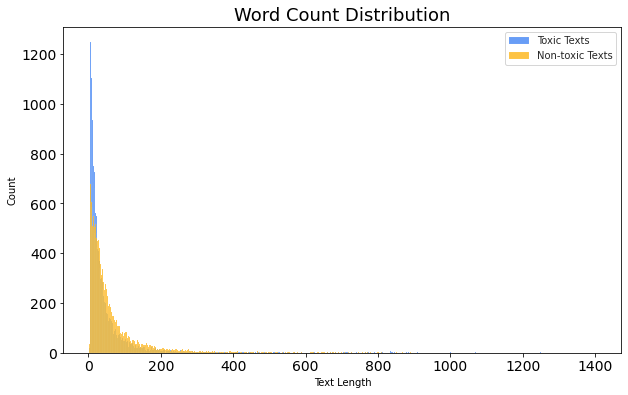

In [16]:
# Calculate word counts
df_downsampled['word_count'] = df_downsampled['cleaned_text'].apply(lambda x: len(x.split(' ')))
df_toxic = df_downsampled[df_downsampled.label == 0]
df_nontoxic = df_downsampled[df_downsampled.label == 1]

### Plot the word-count distribution for the toxic texts and the non toxic texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(df_toxic['word_count'].min(), df_nontoxic['word_count'].min()), 
             max(df_toxic['word_count'].max(), df_nontoxic['word_count'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=df_toxic, x='word_count', label='Toxic Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=df_nontoxic, x='word_count', label='Non-toxic Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)


In [17]:
## Train, Val, Test Split
X_full =  df_downsampled["cleaned_text"]
y_full = df_downsampled["label"]

# Split test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, 
                                                            test_size=0.1,
                                                            random_state=42,
                                                            stratify=y_full
                                                            )

# Split train - dev
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=y_train_val
                                                            )

print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_val.shape)
print('Development Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (23364,)
Train Label Dimension: (23364,)
Development Data Dimension: (5841,)
Development Label Dimension: (5841,)
Test Data Dimension: (3245,)
Test Label Dimension: (3245,)


### 3. Classification Model with BERT

In [18]:
# Load the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Use sequence length 320. From the word count distribution, most posts are within this length.
max_length = 320

train_encodings = bert_tokenizer(
    list(X_train.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

valid_encodings = bert_tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

test_encodings = bert_tokenizer(
    list(X_test.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

train_encodings

{'input_ids': tensor([[  101,  5371, 23736,  ...,     0,     0,     0],
        [  101,  8945,  7174,  ...,     0,     0,     0],
        [  101,  2129,  2055,  ...,     0,     0,     0],
        ...,
        [  101,  2115,  2686,  ...,     0,     0,     0],
        [  101,  2023,  3189,  ...,     0,     0,     0],
        [  101,  2115,  3566,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [27]:
## HYPER-PARAMETERS BLOCKS
import os

BATCH_SIZE = 16
LR =3e-4
WEIGHT_DECAY = 5e-4
EPOCHS = 1
HIDDEN_SIZE = 200
DROP_OUT = 0.1
WORKERS = int(os.cpu_count()/2)

In [20]:
## Data Loader
train_ids = train_encodings.input_ids
train_mask = train_encodings.attention_mask
train_token_type_ids = train_encodings.token_type_ids
train_labels = torch.tensor(y_train.values) 

val_ids = valid_encodings.input_ids
val_mask = valid_encodings.attention_mask
val_token_type_ids = valid_encodings.token_type_ids
val_labels = torch.tensor(y_val.values)

test_ids = test_encodings.input_ids
test_mask = test_encodings.attention_mask
test_token_type_ids = test_encodings.token_type_ids
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_ids, train_mask, train_token_type_ids, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(val_ids, val_mask, val_token_type_ids, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_ids, test_mask, test_token_type_ids, test_labels)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [21]:
class BertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=200, dropout=0.1):
        super(BertClassification, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size, output_dim)

        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask, 
                                      token_type_ids=token_type_ids)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.ReLU(self.hidden_layer(cls_token))
        
        hidden_ouput = self.drop_out(hidden_ouput)
        output = self.Sigmoid(self.classification(hidden_ouput))

        #x = x.flatten()
        return output

In [25]:
model = BertClassification(hidden_size=HIDDEN_SIZE, dropout=DROP_OUT)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [ ]:
## Define train function
def train(train_loader, model, criterion, optimizer, epoch):
    # batch_time = AverageMeter('Time', ':6.3f')
    # data_time = AverageMeter('Data', ':6.3f')
    # losses = AverageMeter('Loss', ':.4e')
    # top1 = AverageMeter('Acc@1', ':6.2f')
    # top5 = AverageMeter('Acc@5', ':6.2f')
    # progress = ProgressMeter(
    #     len(train_loader),
    #     [batch_time, data_time, losses, top1, top5],
    #     prefix="Epoch: [{}]".format(epoch))
    
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode here
    model.train()

    epoch_start = time.time()
    # end = time.time()
    for step, data in enumerate(train_loader):
        # measure data loading time
        # data_time.update(time.time() - end)
    
        # send the data to cuda device
        ids = data[0].to(device)
        mask = data[1].to(device)
        token_type_ids = data[2].to(device)
        target = data[3].to(device)
    
        # compute output
        output = model(ids, mask, token_type_ids)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; 
        #  the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # measure accuracy and record loss
        # acc1, acc5 = accuracy(output, target, topk=(1, 5))
        # losses.update(loss.item(), images.size(0))
        # top1.update(acc1[0], images.size(0))
        # top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 40 batches
        if step % 40 == 0 and not step == 0:
            print('Epoch {:>2}  Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 epoch,
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - epoch_start))) 
        
        ## backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # measure elapsed time
        # batch_time.update(time.time() - end)
        # end = time.time()

        # if i % PRINT_FREQ == 0:
        #     progress.display(i)

  avg_train_loss = total_loss / len(train_loader) 
  elapsed_time = time.time() - epoch_start
  print ("Avg Training Loss {:0.4f}, Completed in {:} ".format(
      avg_train_loss,
      format_time(elapsed_time)
        ))
  
  # return model, avg_train_loss, elapsed_time
  return avg_train_loss, elapsed_time
 

In [ ]:
num_epochs = 1
optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)
criterion = nn.BCELoss()
loss_history = []
accuracy_history = []

model.train()

for step, epoch in range(num_epochs):
    # Reset the gradient to zero
    optimizer.zero_grad()
    
    # prediction
    pred = model4(X_train_dl)
    
    # calculate loss
    loss = criterion(pred, y_train_dl)
    loss_history.append(loss.item())
    
    # compute gradient
    loss.backward()
    
    # Update gradient
    optimizer.step()
    
    # Calculate accuracy
    is_correct = ((pred > 0.5) == y_train_dl).float()
    accuracy_history.append(is_correct.mean())
    
    # Print out result
    print(f'Epoch {epoch}/{num_epochs} - loss: {loss.item():.4f} - accuracy: {is_correct.mean()}')